In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from IPython.display import clear_output
from pydrake.all import (
    AbstractValue,
    AddMultibodyPlantSceneGraph,
    Concatenate,
    DiagramBuilder,
    JointSliders,
    LeafSystem,
    MeshcatPoseSliders,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    Parser,
    PointCloud,
    RandomGenerator,
    Rgba,
    RigidTransform,
    RotationMatrix,
    Simulator,
    StartMeshcat,
    UniformlyRandomRotationMatrix,
)
from manipulation.scenarios import AddMultibodyTriad

from manipulation import running_as_notebook
from manipulation.scenarios import AddFloatingRpyJoint, AddRgbdSensors, ycb
from manipulation.utils import ConfigureParser
import sponana.utils

In [3]:
from sponana.grasping.grasp_generator import get_unified_point_cloud, BananaSystem, ScoreSystem, GenerateAntipodalGraspCandidate

In [4]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7002


In [38]:
# Example banana pose
X_W_Banana = RigidTransform(
    R=RotationMatrix([
        [-0.0003172594814682128, 0.9998758496538035, -0.015753876523125154],
        [-0.9999552082234492, -0.00046622868823287256, -0.009453262802261178],
        [-0.00945943408559755, 0.015750171741753295, 0.9998312113536392],
    ]),
    p=[0.09965310518406117, 3.999831617167207/6, 0.22564659809789764],
)

In [75]:
import sponana.grasping.grasping_models as g
def make_internal_model():
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    parser = Parser(plant)
    sponana.utils.configure_parser(parser)
    parser.AddModelsFromString(
        # g.gripper_only_str()
        g.gripper_and_target_str(
            target_obj_path=g.SUGAR_BOX_TARGET_PATH,
            target_obj_link=g.SUGAR_BOX_TARGET_LINK,
            target_obj_rpy_str=g.SUGAR_BOX_RPY_STR
        ),
        "dmd.yaml"
    )
    # AddModelsFromUrl("package://sponana/grasping/banana_and_spot_gripper.dmd.yaml")
    plant.Finalize()
    return builder.Build()


In [79]:
def grasp_score_inspector(gripper_name="arm_link_wr1", pointcloud_transform=RigidTransform()):
    meshcat.Delete()

    # Finally, we'll build a diagram for running our visualization
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    parser = Parser(plant)
    sponana.utils.configure_parser(parser)
    
    parser.AddModelsFromString(
        g.gripper_and_target_str(
            target_obj_path=g.SUGAR_BOX_TARGET_PATH,
            target_obj_link=g.SUGAR_BOX_TARGET_LINK,
            target_obj_rpy_str=g.SUGAR_BOX_RPY_STR
        ),
        "dmd.yaml"
    )

    AddFloatingRpyJoint(
        plant,
        plant.GetFrameByName(gripper_name),
        plant.GetModelInstanceByName("_gripper"),
    )
    AddMultibodyTriad(plant.GetFrameByName(gripper_name), scene_graph)
    plant.Finalize()

    meshcat.DeleteAddedControls()
    params = MeshcatVisualizerParams(delete_on_initialization_event=False)
    params.prefix = "planning"
    visualizer = MeshcatVisualizer.AddToBuilder(
        builder, scene_graph, meshcat, params
    )

    environment = BananaSystem(g.target_and_cameras_str(
        target_obj_path=g.SUGAR_BOX_TARGET_PATH,
        target_obj_link=g.SUGAR_BOX_TARGET_LINK,
        target_obj_rpy_str=g.SUGAR_BOX_RPY_STR
    ))
    environment_context = environment.CreateDefaultContext()

    cloud = get_unified_point_cloud(
        environment,
        environment_context,
        meshcat=meshcat
    )
    cloud.mutable_xyzs()[:] = pointcloud_transform.multiply(cloud.xyzs())
    meshcat.SetObject("planning/cloud", cloud, point_size=0.003)

    internal_model = make_internal_model()
    score = builder.AddSystem(
        ScoreSystem(internal_model, cloud, gripper_name, plant.GetBodyByName(gripper_name).index(), meshcat=meshcat)
    )
    builder.Connect(plant.get_body_poses_output_port(), score.get_input_port())

    lower_limit = [-1, -1, 0, -np.pi, -np.pi / 4.0, -np.pi / 4.0]
    upper_limit = [5, 5, 1, 0, np.pi / 4.0, np.pi / 4.0]
    q0 = [-0.05, -0.5, 0.25, -np.pi / 2.0, 0, 0]
    default_interactive_timeout = None if running_as_notebook else 1.0
    sliders = builder.AddSystem(
        JointSliders(
            meshcat,
            plant,
            initial_value=q0,
            lower_limit=lower_limit,
            upper_limit=upper_limit,
            decrement_keycodes=[
                "KeyQ",
                "KeyS",
                "KeyA",
                "KeyJ",
                "KeyK",
                "KeyU",
            ],
            increment_keycodes=[
                "KeyE",
                "KeyW",
                "KeyD",
                "KeyL",
                "KeyI",
                "KeyO",
            ],
        )
    )
    diagram = builder.Build()
    sliders.Run(diagram, default_interactive_timeout)
    meshcat.DeleteAddedControls()
    return diagram


diagram = grasp_score_inspector(gripper_name="gripper", pointcloud_transform=X_W_Banana)

INFO:drake:Press the 'Stop JointSliders' button in Meshcat or press 'Escape' to continue.


[[0.01357962 0.01531117 0.01422448 ... 0.08065972 0.0158031  0.01181262]
 [0.6836113  0.6641851  0.68668455 ... 0.68535477 0.6840503  0.68350726]
 [0.2242933  0.22359537 0.22792083 ... 0.30856413 0.31262127 0.31175172]]
Min distance = inf
cost: -19.99999365863669
normal terms: []


In [30]:
# For visualization
def draw_grasp_candidate(X_G, meshcat, gripper_name, prefix="gripper", draw_frames=True):
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    parser = Parser(plant)
    sponana.utils.configure_parser(parser)
    parser.AddModelsFromUrl(
        "package://sponana/grasping/spot_gripper.urdf"
    )
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName(gripper_name), X_G)
    plant.Finalize()

    # frames_to_draw = {"gripper": {"body"}} if draw_frames else {}
    params = MeshcatVisualizerParams()
    params.prefix = prefix
    params.delete_prefix_on_initialization_event = False
    visualizer = MeshcatVisualizer.AddToBuilder(
        builder, scene_graph, meshcat, params
    )
    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.ForcedPublish(context)

In [80]:
def sample_grasps_example(gripper_name="arm_link_wr1", pointcloud_transform=RigidTransform()):
    meshcat.Delete()
    rng = np.random.default_rng()

    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
    parser = Parser(plant)
    sponana.utils.configure_parser(parser)
    
    parser.AddModelsFromString(
        g.gripper_and_target_str(
            target_obj_path=g.SUGAR_BOX_TARGET_PATH,
            target_obj_link=g.SUGAR_BOX_TARGET_LINK,
            target_obj_rpy_str=g.SUGAR_BOX_RPY_STR
        ),
        "dmd.yaml"
    )
    AddFloatingRpyJoint(
        plant,
        plant.GetFrameByName(gripper_name),
        plant.GetModelInstanceByName("_gripper"),
    )
    AddMultibodyTriad(plant.GetFrameByName(gripper_name), scene_graph)
    plant.Finalize()

    params = MeshcatVisualizerParams()
    params.prefix = "planning"
    visualizer = MeshcatVisualizer.AddToBuilder(
        builder, scene_graph, meshcat, params
    )
    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.ForcedPublish(context)

    # Hide the planning gripper
    meshcat.SetProperty("planning/gripper", "visible", False)

    environment = BananaSystem(g.target_and_cameras_str(
        target_obj_path=g.SUGAR_BOX_TARGET_PATH,
        target_obj_link=g.SUGAR_BOX_TARGET_LINK,
        target_obj_rpy_str=g.SUGAR_BOX_RPY_STR
    ))
    environment_context = environment.CreateDefaultContext()
    cloud = get_unified_point_cloud(
        environment,
        environment_context,
        meshcat=meshcat
    )
    cloud.mutable_xyzs()[:] = pointcloud_transform.multiply(cloud.xyzs())
    meshcat.SetObject("planning/cloud", cloud, point_size=0.003)

    plant.GetMyContextFromRoot(context)
    scene_graph.GetMyContextFromRoot(context)

    internal_model = make_internal_model()
    internal_model_context = internal_model.CreateDefaultContext()
    costs = []
    X_Gs = []
    for i in range(1000 if running_as_notebook else 2):
        cost, X_G = GenerateAntipodalGraspCandidate(
            internal_model, internal_model_context, cloud, rng,
            wsg_body_index=internal_model.GetSubsystemByName("plant").GetBodyByName(gripper_name).index(),
        )
        if np.isfinite(cost):
            costs.append(cost)
            X_Gs.append(X_G)

    indices = np.asarray(costs).argsort()[:5]
    for rank, index in enumerate(indices):
        draw_grasp_candidate(
            X_Gs[index], meshcat, gripper_name, prefix=f"{rank}th best", draw_frames=False
        )
    print(X_Gs[0])

    print(costs)

sample_grasps_example(gripper_name="gripper") #, pointcloud_transform=X_W_Banana)

[[-0.0169318   0.00249952 -0.02003947 ... -0.01949365 -0.01820708
  -0.01765454]
 [-0.08609203 -0.08436263 -0.08539154 ... -0.01769379 -0.08247785
  -0.08648127]
 [-0.00015752 -0.00069898  0.00343018 ...  0.08302584  0.08811636
   0.08731495]]
Min distance = inf
[[-0.0169318   0.00249952 -0.02003947 ... -0.01949365 -0.01820708
  -0.01765454]
 [-0.08609203 -0.08436263 -0.08539154 ... -0.01769379 -0.08247785
  -0.08648127]
 [-0.00015752 -0.00069898  0.00343018 ...  0.08302584  0.08811636
   0.08731495]]
Min distance = inf
[[-0.0169318   0.00249952 -0.02003947 ... -0.01949365 -0.01820708
  -0.01765454]
 [-0.08609203 -0.08436263 -0.08539154 ... -0.01769379 -0.08247785
  -0.08648127]
 [-0.00015752 -0.00069898  0.00343018 ...  0.08302584  0.08811636
   0.08731495]]
Min distance = inf
[[-0.0169318   0.00249952 -0.02003947 ... -0.01949365 -0.01820708
  -0.01765454]
 [-0.08609203 -0.08436263 -0.08539154 ... -0.01769379 -0.08247785
  -0.08648127]
 [-0.00015752 -0.00069898  0.00343018 ...  0.0830

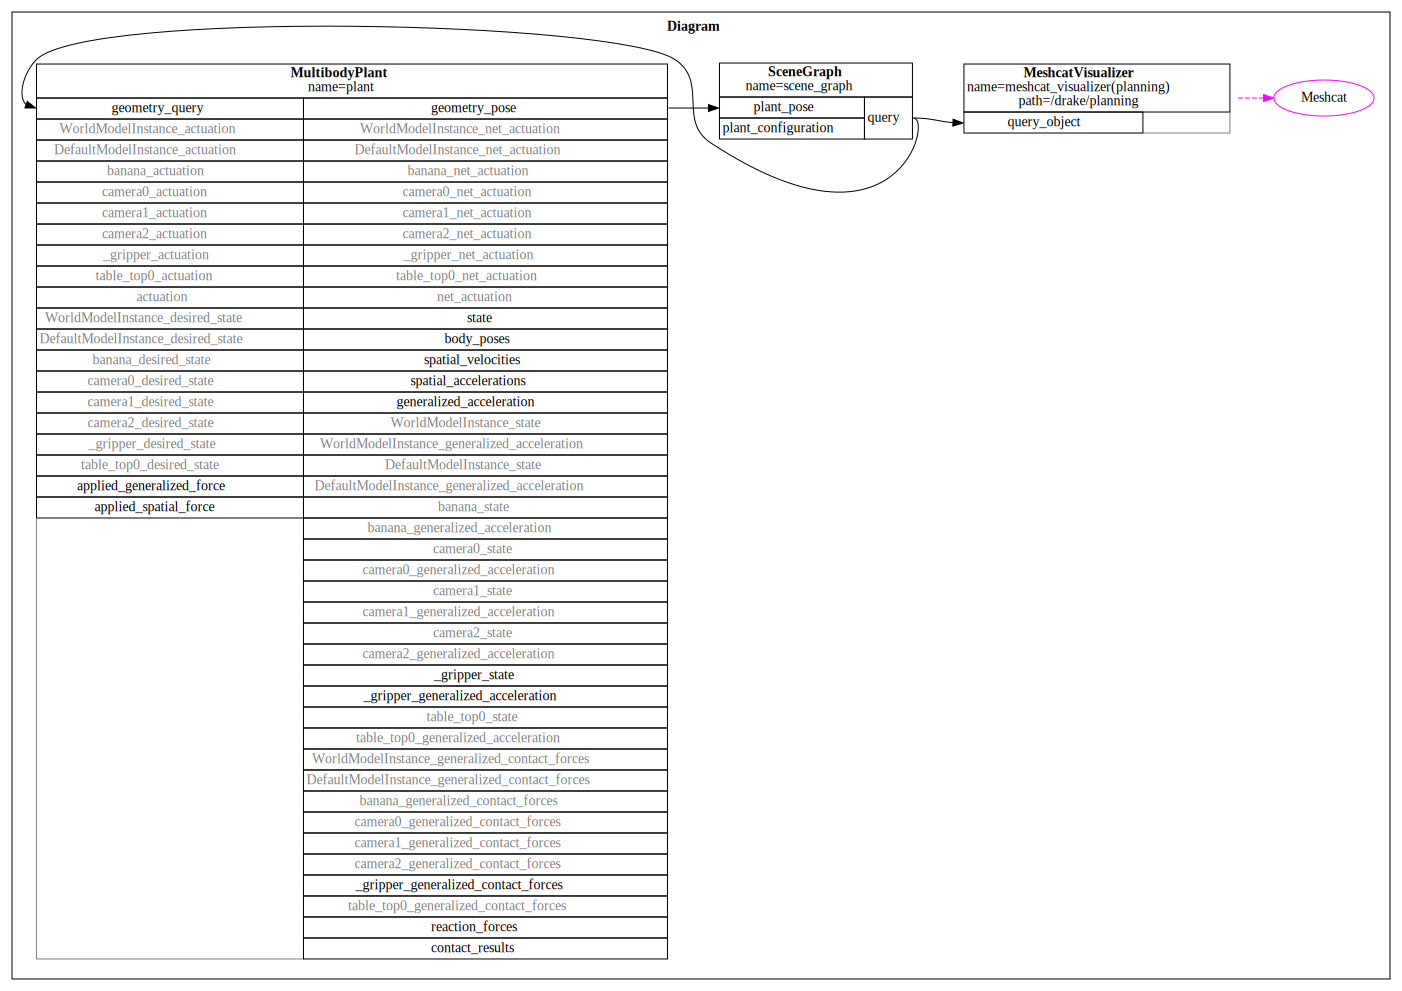

In [12]:
sponana.utils.visualize_diagram(diagram, max_depth=2)

In [ ]:
5

5